In [ ]:
import sys
!{sys.executable} -m pip install git+https://github.com/decibelcooper/nngpt.git

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import logging
logging.basicConfig(
format="%(levelname)s %(funcName)s():%(lineno)i: %(message)s",
)

# Readout segmentation

In [3]:
import numpy as np
import random as rand
from scipy import spatial

# geometry parameters
n_coded_chans = 99
height = 100
width = 100
# pad segmentation for coded readout
k = 100
l = 100
# pad segmentation for pixelated readout on opposing plane
m = 9
n = 9

# build arrays mapping coded readout pads to channel numbers
coded_pitch_y = height / k
coded_pitch_x = width / l

chans = [i for i in range(0, n_coded_chans)]

coded_pad_x = []
coded_pad_y = []
coded_pad_c = []

for i in range(0, k):
    for j in range(0, l):
        coded_pad_y.append(height/2 - (i+0.5)*coded_pitch_y)
        coded_pad_x.append(width/2 - (j+0.5)*coded_pitch_x)

        """
        coded readout selects channels at random
        for each pad from a small pool
        """ 
        coded_pad_c.append(rand.choice(chans))

coded_pad_x = np.array(coded_pad_x)
coded_pad_y = np.array(coded_pad_y)
coded_pad_c = np.array(coded_pad_c)

# build arrays mapping pixelated pads to channel numbers
pixel_pitch_y = height / m
pixel_pitch_x = width / n

pixel_pad_x = []
pixel_pad_y = []
pixel_pad_c = []

for i in range(0, m):
    for j in range(0, n):
        pixel_pad_y.append(height/2 - (i+0.5)*pixel_pitch_y)
        pixel_pad_x.append(width/2 - (j+0.5)*pixel_pitch_x)

        """
        each pad for the pixelated readout gets
        a unique channel
        """ 
        pixel_pad_c.append(n_coded_chans + i*n + j)

pixel_pad_x = np.array(pixel_pad_x)
pixel_pad_y = np.array(pixel_pad_y)
pixel_pad_c = np.array(pixel_pad_c)

# define nearest channel sample binning using native KDTree search
coded_pad_tree = spatial.cKDTree(np.transpose([coded_pad_x, coded_pad_y]))
pixel_pad_tree = spatial.cKDTree(np.transpose([pixel_pad_x, pixel_pad_y]))
def chan_counts(xy, split=True, randomize=True):
    if randomize:
        np.random.shuffle(xy)

    # split the samples evenly between the coded and pixelated planes
    if split:
        xy1 = xy[:len(xy)//2]
        xy2 = xy[len(xy)//2:]
    else:
        xy1 = xy
        xy2 = xy

    # bin the samples by channel
    _, coded_pads = coded_pad_tree.query(xy1)
    coded_pads, coded_counts = np.unique(coded_pads, return_counts=True)
    _, pixel_pads = pixel_pad_tree.query(xy2)
    pixel_pads, pixel_counts = np.unique(pixel_pads, return_counts=True)
    try:
        coded_pads, counts = zip(
            *filter(
                lambda x: x[0] < len(coded_pad_c),
                zip(coded_pads, coded_counts),
            ),
        )
        pixel_pads, counts = zip(
            *filter(
                lambda x: x[0] < len(pixel_pad_c),
                zip(pixel_pads, pixel_counts),
            ),
        )
        return zip(
            np.concatenate(
                [coded_pad_c[list(coded_pads)],
                 pixel_pad_c[list(pixel_pads)]],
            ),
            np.concatenate([coded_counts, pixel_counts]),
        )
    except ValueError:
        return []

# Tomography

In [4]:
import logging
import nngpt

logging.getLogger().setLevel(logging.INFO)

# initialize planar nonnegative gaussian process tomography
p = nngpt.Planar(
    n_coded_chans + m*n,
    chan_counts,
    m=100, n=100,
    sample_density=10000,
)

INFO _init_design():133: g integration time: 114.426
INFO _init_design():178: covariance matrix calculation time: 23.420


In [5]:
import logging
import nngpt
import matplotlib.pyplot as plt

def plot_tomo_for_samples(xy, name, n_std=4, seg_name='coded-pixelated'):
    logging.getLogger().setLevel(logging.INFO)

    xy_diff = nngpt.add_diffusion(xy, p.max_diff_sigma)
    q = p.bin_channels(xy_diff)
    img = p.tomo(q)
    mean, cov = p.get_mean_and_cov(img)
    true_img = p.bin_pixels(xy)
    true_mean, true_cov = p.get_mean_and_cov(true_img)

    print('Simulated channel input')
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot()
    ax.plot(q)
    ax.set_xlabel('readout channel')
    ax.set_yscale('log')
    fig.savefig(f'{seg_name}_{name}_channel-response.pdf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()

    print(f'True image with calculated {n_std}-sigma confidence ellipse')
    fig = nngpt.draw_tomo(
        true_img, p.width, p.height, colorbar=True,
        mean=[None], cov=[None],
        true_mean=[[true_mean]], true_cov=[[true_cov]],
        n_std=n_std,
    )
    for ax in fig.axes:
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        break
    fig.savefig(f'{name}_truth-img.pdf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
    print(f'Reconstructed image with overlayed confidence ellipses')
    fig = nngpt.draw_tomo(
        img, p.width, p.height, colorbar=True,
        true_mean=[[true_mean]], true_cov=[[true_cov]],
        mean=[[mean]], cov=[[cov]],
        n_std=n_std,
    )
    for ax in fig.axes:
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        break
    fig.savefig(f'{seg_name}_{name}_reco-img.pdf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
    print('Differences in the images and overlayed confidence ellipses')
    fig = nngpt.draw_tomo(
        img-true_img, p.width, p.height, colorbar=True,
    )
    for ax in fig.axes:
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        break
    fig.savefig(f'{seg_name}_{name}_diff-img.pdf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()

## Covariant Gaussian

INFO sample_normal():16: sampling time: 0.126
INFO add_diffusion():67: sampling time: 0.163
INFO bin_channels():59: binning time: 1.764
INFO tomo():41: tomography time: 3.343
INFO tomo():42: tomography iterations: 11
INFO tomo():43: unconstrained pixel count: 218
INFO bin_pixels():72: binning time: 0.732


Simulated channel input


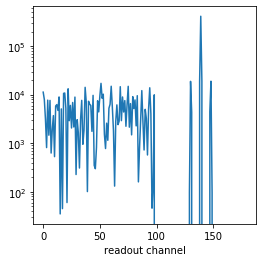

True image with calculated 4-sigma confidence ellipse


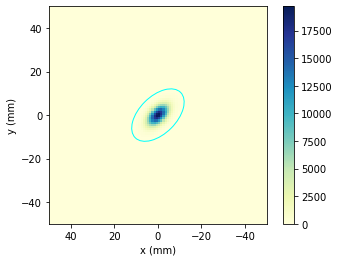

Reconstructed image with overlayed confidence ellipses


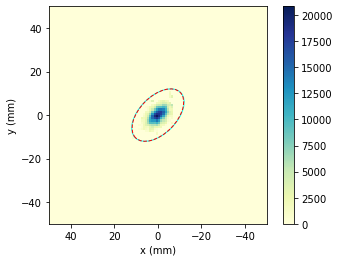

Differences in the images and overlayed confidence ellipses


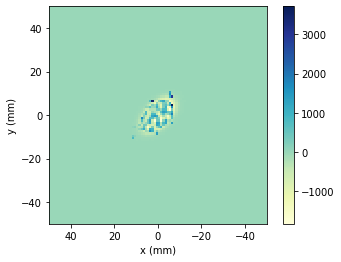

In [6]:
import nngpt
import numpy as np

means = np.array([[0,0]])
covs = 9*np.array([[[1,-0.5],[-0.5,1]]])
n_samples = [1e6]

xy = nngpt.sample_normal(means, covs, n_samples)
plot_tomo_for_samples(xy, 'cov-gauss')

## Two Gaussians

INFO sample_normal():16: sampling time: 0.177
INFO add_diffusion():67: sampling time: 0.230
INFO bin_channels():59: binning time: 3.309
INFO tomo():41: tomography time: 0.102
INFO tomo():42: tomography iterations: 13
INFO tomo():43: unconstrained pixel count: 223
INFO bin_pixels():72: binning time: 1.204


Simulated channel input


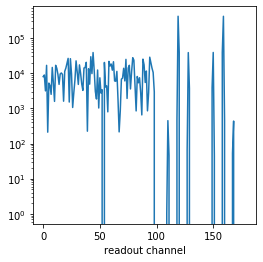

True image with calculated 4-sigma confidence ellipse


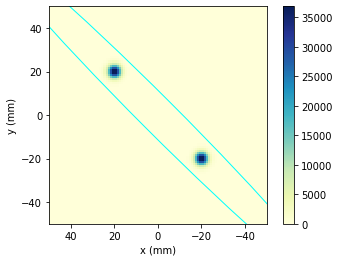

Reconstructed image with overlayed confidence ellipses


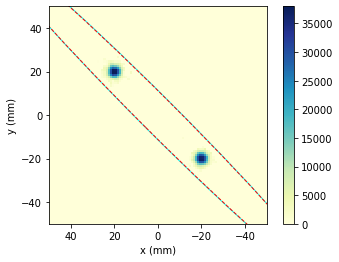

Differences in the images and overlayed confidence ellipses


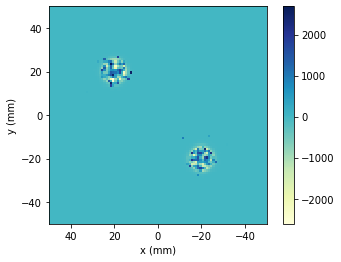

In [7]:
import nngpt
import numpy as np

means = 20*np.array([[1,1],[-1,-1]])
covs = 4*np.array([[[1,0],[0,1]],[[1,0],[0,1]]])
n_samples = [1e6,1e6]

xy = nngpt.sample_normal(means, covs, n_samples)
plot_tomo_for_samples(xy, 'double-gauss')

## Circle convolved with Gaussian

INFO sample_circle():33: sampling time: 1.787
INFO add_diffusion():67: sampling time: 1.433
INFO bin_channels():59: binning time: 17.507
INFO tomo():41: tomography time: 0.110
INFO tomo():42: tomography iterations: 16
INFO tomo():43: unconstrained pixel count: 688
INFO bin_pixels():72: binning time: 6.690


Simulated channel input


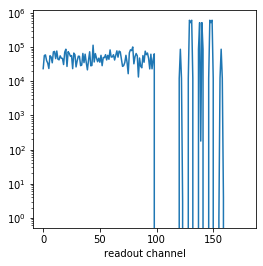

True image with calculated 4-sigma confidence ellipse


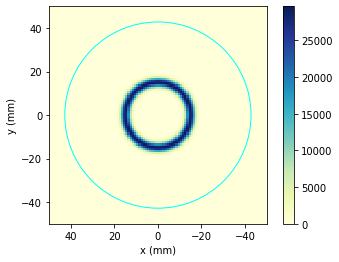

Reconstructed image with overlayed confidence ellipses


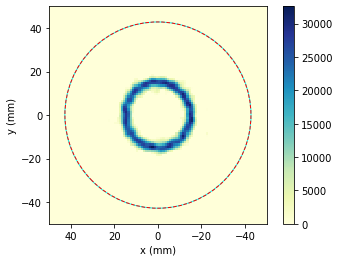

Differences in the images and overlayed confidence ellipses


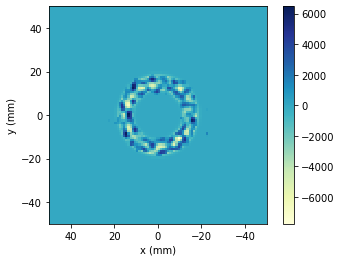

In [8]:
import nngpt

xy = nngpt.sample_circle()
plot_tomo_for_samples(xy, 'circle')

## Square convolved with Gaussian

INFO sample_square():54: sampling time: 1.158
INFO add_diffusion():67: sampling time: 1.102
INFO bin_channels():59: binning time: 17.621
INFO tomo():41: tomography time: 0.091
INFO tomo():42: tomography iterations: 13
INFO tomo():43: unconstrained pixel count: 655
INFO bin_pixels():72: binning time: 6.463


Simulated channel input


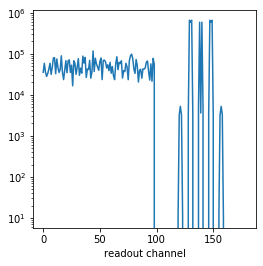

True image with calculated 4-sigma confidence ellipse


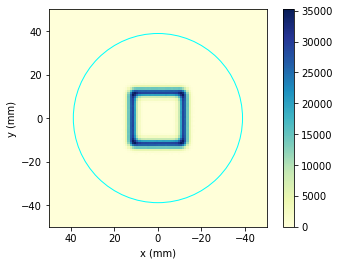

Reconstructed image with overlayed confidence ellipses


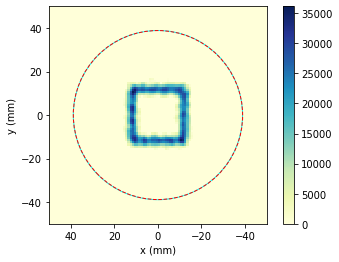

Differences in the images and overlayed confidence ellipses


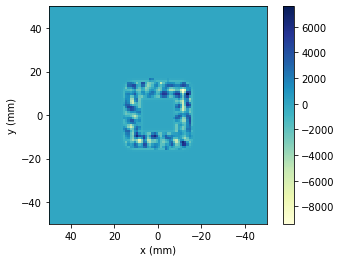

In [9]:
import nngpt

xy = nngpt.sample_square()
plot_tomo_for_samples(xy, 'square')

## Execution time benchmark using covariant Gaussian

In [10]:
import logging
import nngpt

logging.getLogger().setLevel(logging.ERROR)

means = np.array([[0,0]])
covs = 9*np.array([[[1,-0.5],[-0.5,1]]])
n_samples = [1e6]

xy = nngpt.sample_normal(means, covs, n_samples)
xy_diff = nngpt.add_diffusion(xy, p.max_diff_sigma)
q = p.bin_channels(xy_diff)

%timeit p.tomo(q, ret_pixels=False)

68.9 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
